In [1]:
import pandas as pd

In [2]:
# Read two datasets into dataframes and concatenate into one dataset: crime_df

crime_17_df = pd.read_csv("data/chicago_crime_2017.csv")
crime_18_df = pd.read_csv("data/chicago_crime_2018.csv")
crime_df = pd.concat([crime_17_df, crime_18_df])

In [35]:
crime_df.head(10)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11094370,JA440032,09/21/2017 12:15:00 AM,072XX N CALIFORNIA AVE,1122,DECEPTIVE PRACTICE,COUNTERFEIT CHECK,CURRENCY EXCHANGE,True,False,...,50.0,2.0,10,1156443.0,1947707.0,2017,03/01/2018 03:52:35 PM,42.012293,-87.699714,"(42.012293397, -87.699714109)"
1,11118031,JA470589,10/12/2017 07:14:00 PM,055XX W GRAND AVE,1345,CRIMINAL DAMAGE,TO CITY OF CHICAGO PROPERTY,JAIL / LOCK-UP FACILITY,True,False,...,29.0,19.0,14,1138788.0,1913480.0,2017,03/01/2018 03:52:35 PM,41.918712,-87.765511,"(41.918711651, -87.76551063)"
2,11134189,JA491697,10/30/2017 11:52:00 AM,043XX S TALMAN AVE,4651,OTHER OFFENSE,SEX OFFENDER: FAIL REG NEW ADD,APARTMENT,True,False,...,12.0,58.0,26,1159425.0,1875711.0,2017,03/01/2018 03:52:35 PM,41.814670,-87.690727,"(41.814669784, -87.690726696)"
3,11156462,JA521389,09/29/2017 06:45:00 PM,055XX W BELMONT AVE,1110,DECEPTIVE PRACTICE,BOGUS CHECK,CURRENCY EXCHANGE,True,False,...,30.0,19.0,11,1138653.0,1920720.0,2017,03/01/2018 03:52:35 PM,41.938581,-87.765831,"(41.938581442, -87.765830579)"
4,11164874,JA531910,12/01/2017 06:20:00 AM,022XX W CHICAGO AVE,0265,CRIM SEXUAL ASSAULT,AGGRAVATED: OTHER,STREET,True,False,...,32.0,24.0,02,1161264.0,1905292.0,2017,03/01/2018 03:52:35 PM,41.895805,-87.683159,"(41.895805099, -87.683159355)"
5,10974196,JA298243,06/08/2017 04:02:00 PM,001XX E 59TH ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,ALLEY,True,False,...,20.0,40.0,15,1178308.0,1865932.0,2017,02/11/2018 03:54:58 PM,41.787427,-87.621759,"(41.78742694, -87.621758727)"
6,10995008,JA322389,06/25/2017 07:00:00 PM,003XX W 103RD ST,031A,ROBBERY,ARMED: HANDGUN,SMALL RETAIL STORE,True,False,...,9.0,49.0,03,1175895.0,1836626.0,2017,02/11/2018 03:54:58 PM,41.707062,-87.631483,"(41.707062135, -87.631482564)"
7,11086755,JA430240,09/06/2017 01:30:00 PM,032XX W 26TH ST,0810,THEFT,OVER $500,OTHER,True,False,...,12.0,30.0,06,1155313.0,1886555.0,2017,02/11/2018 03:54:58 PM,41.844510,-87.705519,"(41.844510467, -87.705519454)"
8,11162428,JA529032,11/28/2017 09:43:00 PM,026XX S CALIFORNIA BLVD,5131,OTHER OFFENSE,VIOLENT OFFENDER: ANNUAL REGISTRATION,JAIL / LOCK-UP FACILITY,True,False,...,12.0,30.0,26,1158280.0,1886310.0,2017,02/11/2018 03:54:58 PM,41.843778,-87.694638,"(41.843778126, -87.694637678)"
9,11175304,JA545986,12/11/2017 07:15:00 PM,007XX N SACRAMENTO BLVD,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,True,False,...,27.0,23.0,03,1156092.0,1904769.0,2017,02/11/2018 03:54:58 PM,41.894476,-87.702169,"(41.894475919, -87.702169158)"


In [36]:
crime_df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [96]:
type_count_df = crime_df.groupby(["Primary Type", "Year"]).size().to_frame("Count")
type_count_df["Total"] = type_count_df.groupby(level=0)["Count"].transform("sum")
type_count_df = type_count_df.sort_values(['Total', "Year"], ascending=False)
type_count_df.head(20)

Count   Total
Primary Type        Year               
THEFT               2018  65079  129425
                    2017  64346  129425
BATTERY             2018  49782   98996
                    2017  49214   98996
CRIMINAL DAMAGE     2018  27806   56848
                    2017  29042   56848
ASSAULT             2018  20377   39680
                    2017  19303   39680
DECEPTIVE PRACTICE  2018  18725   37753
                    2017  19028   37753
OTHER OFFENSE       2018  17129   34356
                    2017  17227   34356
BURGLARY            2018  11729   24730
                    2017  13001   24730
NARCOTICS           2018  12987   24645
                    2017  11658   24645
ROBBERY             2018   9683   21560
                    2017  11877   21560
MOTOR VEHICLE THEFT 2018   9987   21393
                    2017  11406   21393

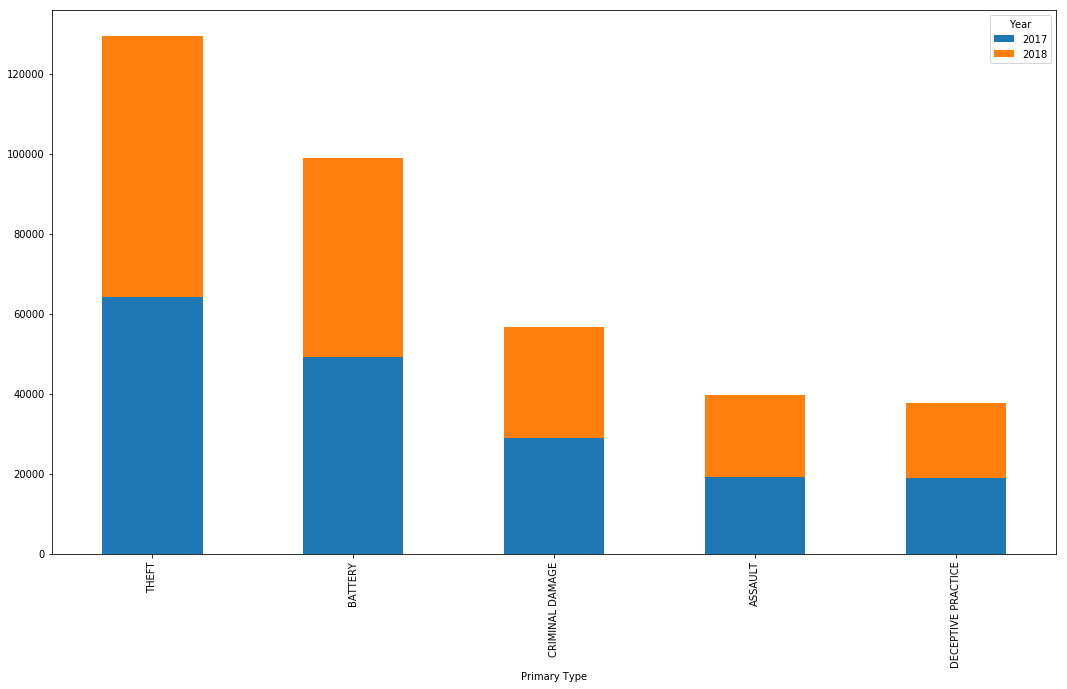

In [99]:
#fig = crime_count_df[:5].plot.bar(rot=0, figsize=(18,5))
fig = type_count_df[:10].Count.unstack().plot.bar(stacked=True, figsize=(18,10))